# Bayesian parameter estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special
import scipy.optimize

import mscl_utils as mscl
colors = mscl.set_plotting_style()
%matplotlib inline

##  Setting up the problem

The parameter that I am interesting in estimating is the survival probability of a given strain expressing MscL channels with a specific RBS. For a first pass, I can ignore the actual fluorescence information and just consider bulk survival probability for each RBS. In the future, when I actually include the fluorescence information, I will need to do some kind of binning to extend this further.

## The model

This data is simply boolean (either lived or died), meaning that I would expect survival to be binomial distributed with some probability $p$. WE can estimate this parameter using Bayes's theorem which says

$$
P(p \,\vert\, s) = {P(s\, \vert\, p) P(p) \over P(s)}
$$

where $s$ is the number of survivors and $p$ is the survival probability. We can write our likelihood as the binomial distribution,

$$
P(s \,\vert\, p) = {N! \over s!(N-s)!}p^s (1 - p)^{N-s}
$$

where $N$ is the total number of cells queried for survival. We need to set a prior on $p$. Since we are being completely uniformative, we know that it must be uniform on the range $(0, 1)$,

$$
p(p) = \begin{cases} 1   & 0 \leq p \leq 1\\
 0 & \text{otherwise}
 \end{cases}.
$$

Now all we are left with is defining the evidence, $P(s)$. I can acknowledge that given $N$ trials, I can have any number of survivors up to a maximum of $N$. However, I can also have 0 survivors, meaning that I have $N + 1$ possibilities. Assuming each has equal weighting, I can define the evidence as 

$$
P(s) ={1 \over N + 1}. 
$$

We can write our full posterior probability distribution as 

$$
P(p\,\vert\, s) = \begin{cases}
{(N + 1)! \over s!(N-s)!}p^s(1 - p)^{N-s} & 0 \leq p \leq 1\\
0 & \text{otherwise}
\end{cases}
$$

with this completely marginalized posterior, we can solve for the distribution via optimization. 

##  Parameter estimation via optimization

Given the equations above, I've written the code required to perform the optimization below. 

In [4]:
def log_posterior(p, s, N):
    """
    Computes the log posterior of the our statistical model. 
    For speedy calculation, we define n! to be the gamma function Γ(n+1).
    
    Parameters
    ----------
    p : 1d-array or float between 0 and 1
        The probability of survival. This is the parameter we will estimate. 
    s : int
        Number of survivors. 
    N : int 
        Total number of cells queried for survival.
    
    Returns
    -------
    log_post :  float
        The log of the posterior probability distribution.
    
    Raises
    ------
    TypeError :
        TypeError exception is given if either s or N are not integer valued.
    """
    # Make sure s and N are integers.
    if (type(s) is not int) or (type(N) is not int):
        raise TypeError('s and N must be ints.')
    
    # Compute the log Binomial coefficient. 
    log_binom = scipy.special.gammaln(N + 2) - scipy.special.gammaln(s + 1) -\
            scipy.special.gammaln(N - s + 1)
    
    # Compute and return the log posterior.
    log_post = log_binom + s * np.log(p) + np.log(1 - p) * (N - s)
    return log_post

Now we can test this out on some "fake" data to make sure that the functions are working as expected. 

/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log


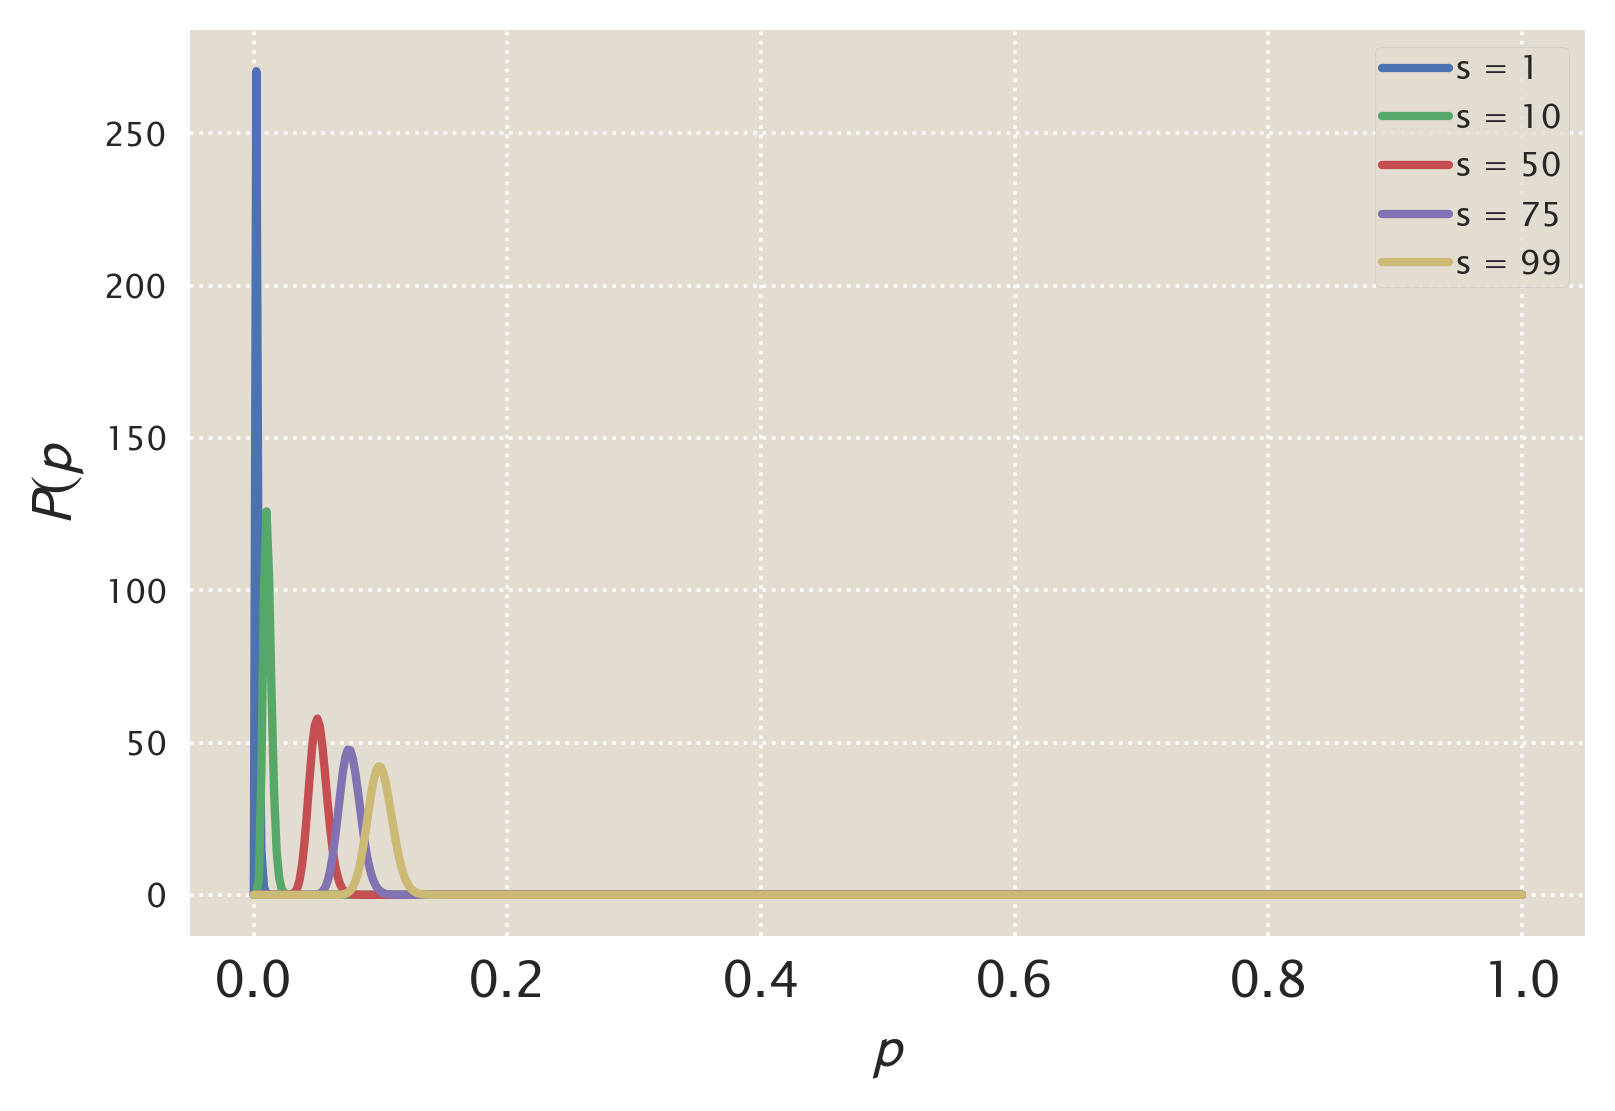

In [13]:
# Generate some fake boolean data. 
s = [1, 10, 50, 75, 99]
N = 1000
p = np.linspace(0, 1, 500)
# Evaluate the log posterior using scipy.optimize.minimize
for i, _ in enumerate(s):
    log_post = log_posterior(p, s[i], N)
    plt.plot(p, np.exp(log_post), '-', label='s = {0}'.format(s[i]))
plt.xlabel('$p$', fontsize=14)
plt.ylabel('$P(p\vert s, N)$', fontsize=14)
plt.legend()